## Beam profile
_Phil Bull, 2023-01-09_   + HG

This notebook uses hera_sim to generate a simple global signal simulation that gets a beam profile from east to west.

It places the telescope at the equator and a single source is simulated going overhead from horizon to horizon.

Change Ntimes and dt to set the time resolution of the obervation, but the total time should be 12 hrs.

Set the beam in Primary Beams, it must be defined in beams.yaml.

In [87]:
import numpy as np
import pylab as plt

import pyuvdata
from pyuvdata import UVData, UVCal
import hera_sim, vis_cpu, pyuvsim
from hera_sim.visibilities import VisibilitySimulation, ModelData ##VisCPU

import astropy
from astropy import units as u
from astropy.coordinates import EarthLocation, SkyCoord, AltAz
from astropy.time import Time

import time, json, h5py

import pygdsm
import pyradiosky
import healpy as hp
import astropy_healpix

import matplotlib.patches as patches

from beam_show_ops import load_beam

plt.rcParams["figure.figsize"] = (10, 5)

np.seterr(all="warn")

# matshow can only plot real, so convert complex values. Dunno if this is appropriate. Maybe should be np.real
check_c = lambda a: a if not isinstance(a[0, 0], complex) else np.abs(a)

## Table of Contents

* [Simulation parameters](#params)
* [Utility functions](#utils)
* [Simple antenna gain model](#gains)
* [Primary beams](#beams)
* [Diffuse emission](#diffuse)
* [Point sources from catalogue](#ptsrc-cat)
* [Synthetic point source catalogue](#ptsrc-synthetic)
* [Simulate point source visibilities](#ptsrc-sim)
* [21cm signal](#21cm)
* [Noise diode](#ndiode)
* [Combined sky and calibrator signals](#skycal)
* [Calibration loads](#loads)
* [Reflections](#reflections)
* [Applying gains](#apply-gains)
* [Save data](#save-data)

<a id='params'></a>
## Simulation parameters

In [88]:
# Frequencies and times
Nfreqs = 280
Ntimes = 72   # Ntimes*dt is the total observation time
dt = 600. # 2 sec
jd = 2458116.4794907407 

# Site location
site_lat = 0 # deg
site_lon = 0 # deg
site_height = 0 # m

# Random seed
random_seed = 4

# Frequency array
freqs = np.linspace(60., 88., Nfreqs) # MHz

# Diffuse model properties
diffuse_sim_nblocks = 5 # chunk in frequency to reduce memory reqs
diffuse_nside = 16 # Diffuse map nside

# Bandpass parameters (Chebyshev)
bandpass_ncoeffs = 50 #12
bandpass_ripple_factor = 0.01
bandpass_rolloff_scale_low = 1.
bandpass_rolloff_scale_high = 1.

# Correlated gain parameters
gain_corr_beta = -1.1
gain_corr_scale = 5.
fknee = 1. / (200.) # 200 sec

# Instrumental noise
Tinstrument = 300. # K

# Noise diode parameters
Tdiode = 60. # K
ndiode_ncoeffs = 20
ndiode_ripple_factor = 0.0005
ndiode_cadence = 10
ndiode_duration = 2
ndiode_gain = 10.
ndiode_bandpass_ncoeffs = 6
ndiode_bandpass_ripple_factor = 0.0005

# Calibration loads
Tload1 = 293. # K
load1_time_ncoeffs = 6
load1_time_amp = 3e-4
load1_freq_ncoeffs = 6
load1_freq_amp = 3e-4

Tload2 = 393. # K
load2_time_ncoeffs = 6
load2_time_amp = 3e-4
load2_freq_ncoeffs = 6
load2_freq_amp = 3e-4

# Noise-wave reflection parameters
Gamma_src_re0 = 0.01
Gamma_src_im0 = 0.01
Gamma_src_time_ncoeffs = 4
Gamma_src_time_amp = 0.5
Gamma_src_freq_ncoeffs = 8
Gamma_src_freq_amp = 0.5

Gamma_rec_re0 = 0.02
Gamma_rec_im0 = 0.02
Gamma_rec_time_ncoeffs = 4
Gamma_rec_time_amp = 0.5
Gamma_rec_freq_ncoeffs = 8
Gamma_rec_freq_amp = 0.5

# Noise-wave temperature parameters
Tunc0 = 250. # K
Tcos0 = 190. # K
Tsin0 = 90. # K
Toffset0 = 0. # K

Tunc_time_ncoeffs = 6
Tunc_time_amp = 1e-2
Tunc_freq_ncoeffs = 6
Tunc_freq_amp = 1e-2

Tcos_time_ncoeffs = 6
Tcos_time_amp = 1e-2
Tcos_freq_ncoeffs = 6
Tcos_freq_amp = 1e-2

Tsin_time_ncoeffs = 6
Tsin_time_amp = 1e-2
Tsin_freq_ncoeffs = 6
Tsin_freq_amp = 1e-2

Toffset_time_ncoeffs = 6
Toffset_time_amp = 1e-2
Toffset_freq_ncoeffs = 6
Toffset_freq_amp = 1e-2

# Output prefix
prefix = "sim_global"

In [89]:
np.random.seed(random_seed)

In [90]:
# Jodrell Bank location
location = EarthLocation.from_geodetic(lat=site_lat,
                                       lon=site_lon,
                                       height=site_height)

# Observation time
obstime = Time(jd, format='jd')
print(obstime.iso)

# Time offsets from 'obstime'
times = np.linspace(0., Ntimes*dt, Ntimes) * u.second

2017-12-28 23:30:28.000


In [91]:
lsts = []
for tt in times:
    frame = AltAz(obstime=obstime + tt, location=location)
    lsts.append((obstime + tt).sidereal_time('apparent', longitude=location.lon).rad)
lsts = np.array(lsts)

In [92]:
# Construct array
ants = {0: [0., 0., 0.]}

<a id='utils'></a>
### Utility functions

In [93]:
def Jy_to_TRJ(flux, freqs, omega):
    """
    Convert data in Jy to units of T_RJ (Kelvin).
    
    Parameters:
        flux (array_like):
            Array of shape (Ntimes, Nfreqs) in Jy units.
        freqs (array_like):
            Frequencies, in MHz.
        omega (array_like):
            Beam solid angle (sterad.) as a function of frequency.
    
    Returns:
        Trj (array_like):
            Input flux array rescale to T_RJ units.
    """
    assert len(flux.shape) == 2, "`flux` must have shape (Ntimes, Nfreqs)"
    assert flux.shape[1] == freqs.size, "`flux` must have shape (Ntimes, Nfreqs)"
    assert omega.size == freqs.size, "`omega' must have shape (Nfreqs,)"
    
    # Define constants
    kB = 1.380649e-23 # m^2 kg s^-2 K^-1
    C = 299792458. # m/s
    
    # Perform conversion
    lam = C / (freqs * 1e6) # wavelength, in m
    fac = lam**2. / (2. * kB * omega) * 1e-26
    Trj = flux * fac[np.newaxis,:]
    return Trj

In [94]:
def chebyshev_model(x, ncoeffs, amp):
    """
    This convenience function produces a Chebyshev series model in 
    frequency/time/etc. to produce a model for various components 
    and systematic effects.
    
    Parameters:
        x (array_like):
            Time/freq. variable.
        ncoeffs (int):
            No. of Chebyshev coefficients to use.
        amp (float):
            Overall amplitude of the Chebyshev polynomial.
    
    Returns:
        fn (array_like):
            Chebyshev function. 
    """
    # Chebyshev parameters
    coeffs = amp * np.random.randn(ncoeffs)

    # Construct time- and frequency-dependent random Chebyshev functions
    xx = np.linspace(-1., 1., x.size)
    fn = np.polynomial.chebyshev.Chebyshev(coeffs)(xx)
    
    # Return values
    return fn

In [95]:
def get_beam_area(beam, freqs, naz=200, nza=300, beam_squared=False):
    
    # Regular grid in azimuth and zenith angle
    _az = np.linspace(0., 2.*np.pi, naz)
    _za = np.linspace(0., 0.5*np.pi, nza)
    az, za = np.meshgrid(_az, _za)
    
    # Get pixel sizes
    pix_az = _az[1] - _az[0]
    pix_za = _za[1] - _za[0]
    
    # Interpolate beam vs frequency
    beam.peak_normalize()
    b, _ = beam.interp(az_array=az.flatten(), za_array=za.flatten(), freq_array=freqs*1e6)
   
    # Reshape to (Nfreqs, Naz, Nza)
    b = b[0,0,1,:,:].copy()
    b = b.reshape((Nfreqs, az.shape[0], az.shape[1]))
    if beam_squared:
        b *= b
    
    # Multiply by sin(alt) and then sum to approximate integral
    b *= np.sin(0.5*np.pi - za)[np.newaxis,:,:]
    area = np.sum(b, axis=(1,2)) * (pix_az * pix_za)
    return area

<a id='gains'></a>
### Simple antenna gain model
The gains will be subject to bandpass effects, 1/f noise and so on.

fknee = 5.00 mHz


divide by zero encountered in power


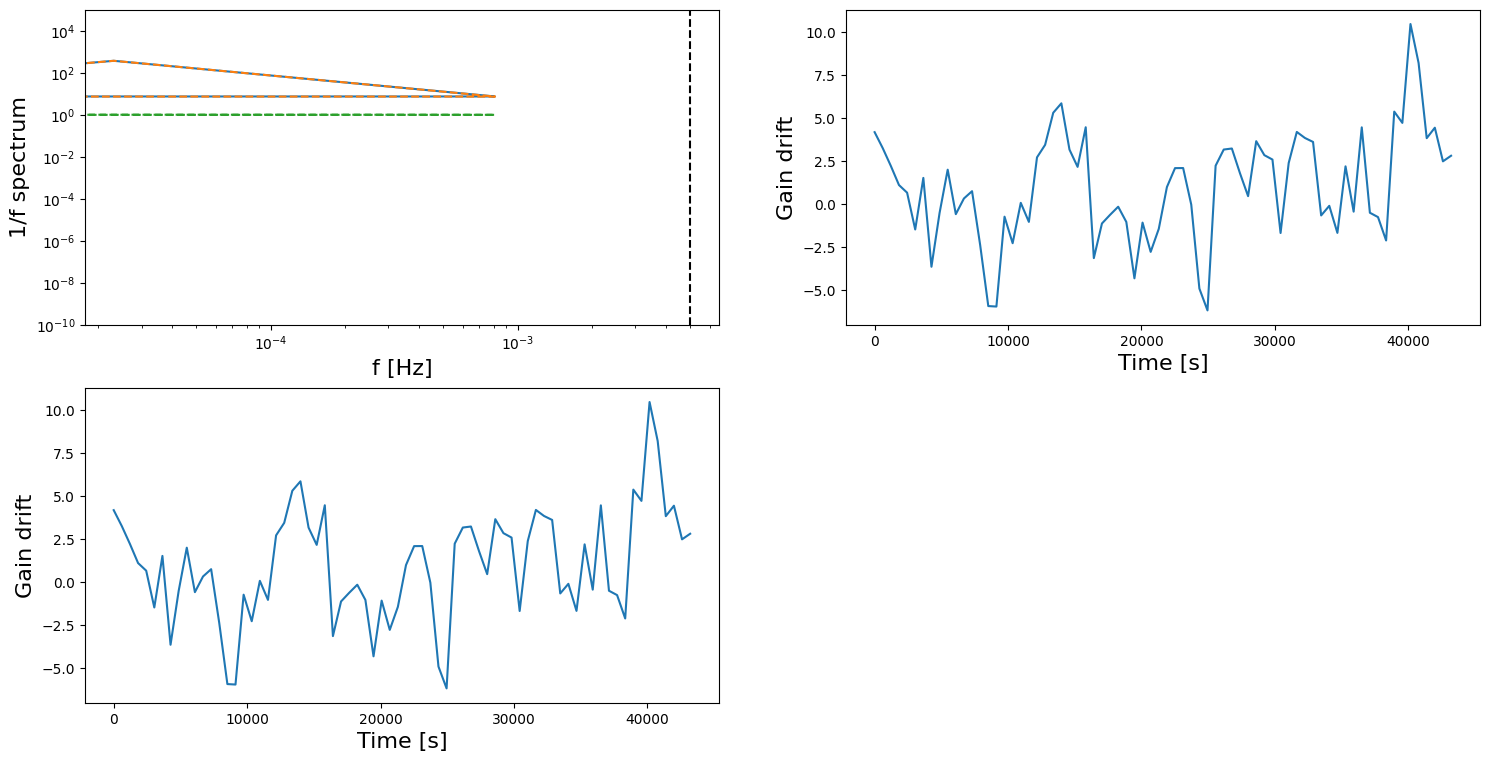

In [96]:
# 1/f noise as gain drifts
print("fknee = %3.2f mHz" % (fknee * 1e3))

# Do FFT on sqrt of power
ff = np.fft.fftfreq(Ntimes, d=dt)
corr_power = (np.abs(ff) / fknee)**gain_corr_beta
corr_power[ff == 0.] = 0.

# Add cutoff above knee frequency, for smoothing
rolloff_scale = fknee # Hz
rolloff = np.exp(-0.5*(np.abs(ff))**2. / rolloff_scale**2.)

# Do FFT of series of ones to get correlated gain rms
nn = np.random.randn(Ntimes) + 1.j*np.random.randn(Ntimes)
gain_corr = 1. + gain_corr_scale * np.fft.ifft(np.sqrt(corr_power*rolloff) * nn).real

# Plot 1/f spectrum
plt.subplot(221)
plt.plot(ff, corr_power)
plt.plot(ff, corr_power*rolloff, ls='dashed')
plt.plot(ff, rolloff, ls='dashed')
plt.axvline(fknee, color='k', ls='dashed')

plt.xscale('log')
plt.yscale('log')
plt.xlabel("f [Hz]", fontsize=16)
plt.ylabel("1/f spectrum", fontsize=16)

plt.ylim((1e-10, 1e5))

# Plot correlated gain drift
plt.subplot(222)
plt.plot(times, gain_corr)
plt.xlabel("Time [s]", fontsize=16)
plt.ylabel("Gain drift", fontsize=16)


# Zoom in on correlated gain drift
plt.subplot(223)
plt.plot(times[:400], gain_corr[:400])
plt.xlabel("Time [s]", fontsize=16)
plt.ylabel("Gain drift", fontsize=16)

plt.gcf().set_size_inches((18., 9.))

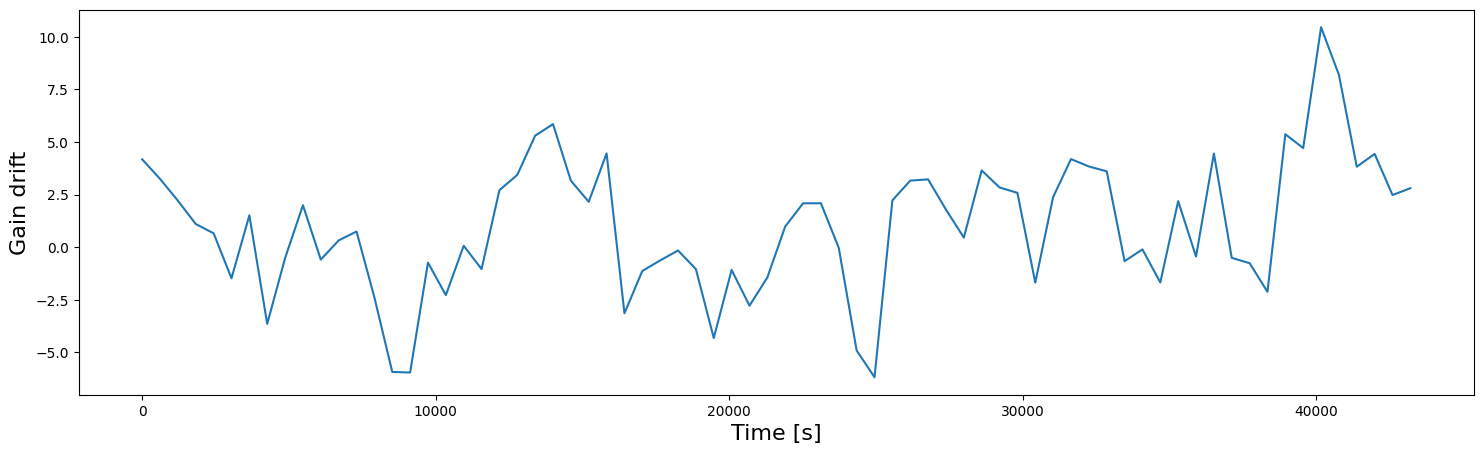

In [97]:
# Plot correlated gain drift in a bigger format
plt.subplot(111)
plt.plot(times, gain_corr)
plt.xlabel("Time [s]", fontsize=16)
plt.ylabel("Gain drift", fontsize=16)

plt.gcf().set_size_inches((18., 5.))

Text(0, 0.5, 'Bandpass')

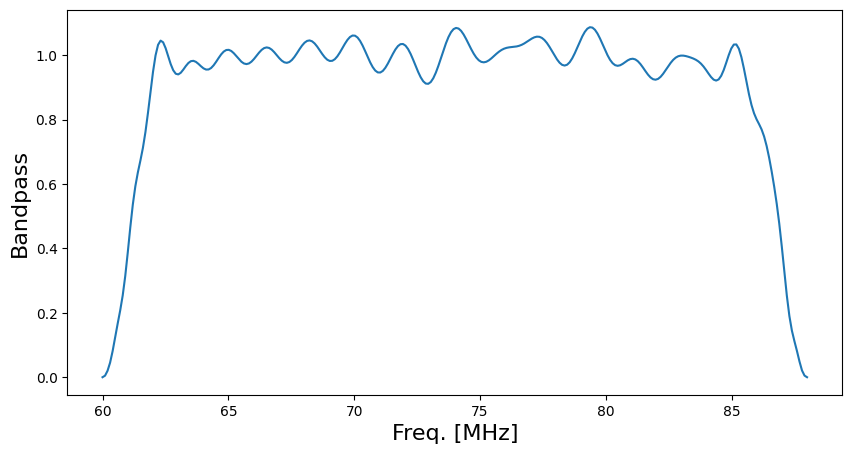

In [98]:
# Bandpass
# Use Chebyshev to simulate some ripples and add a steep roll-off
bandpass_shape = 1. + chebyshev_model(freqs, bandpass_ncoeffs, bandpass_ripple_factor)

# Make band-edge roll-offs
rolloff1 = 1. - np.exp(-0.5*((freqs - freqs[0]) / bandpass_rolloff_scale_low)**2.)
rolloff2 = 1. - np.exp(-0.5*((freqs - freqs[-1]) / bandpass_rolloff_scale_high)**2.)

# Construct bandpass with rolloffs
bandpass = bandpass_shape * rolloff1 * rolloff2

plt.subplot(111)
plt.plot(freqs, bandpass)

plt.xlabel("Freq. [MHz]", fontsize=16)
plt.ylabel("Bandpass", fontsize=16)

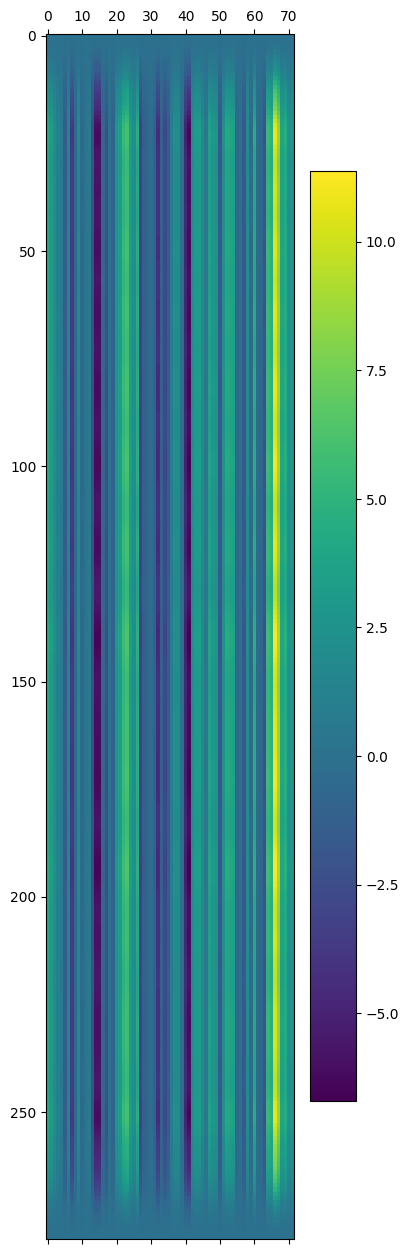

In [99]:
plt.matshow(bandpass[:,np.newaxis] * gain_corr[np.newaxis,:], aspect='auto')
plt.colorbar()

<a id='beams'></a>
## Primary beams
Beam is specified here. Must have an entry in beams.yaml.

In [100]:
import yaml

beam_spec = "rhino1"                   # BEAM_SPEC will be set at pipeline execution time. It must be defined in beams.yaml.   
with open('beams.yaml', 'r') as file:
    beam_cfg = yaml.safe_load(file)[beam_spec]

beams = [ load_beam(beam_cfg, convert_sparse_to_sim_sparse=True, interp_freq_array=freqs*1e6, interp_freq_chunk=40) ]

prefix = prefix+"_"+beam_spec 
print(prefix)

sim_global_rhino1


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

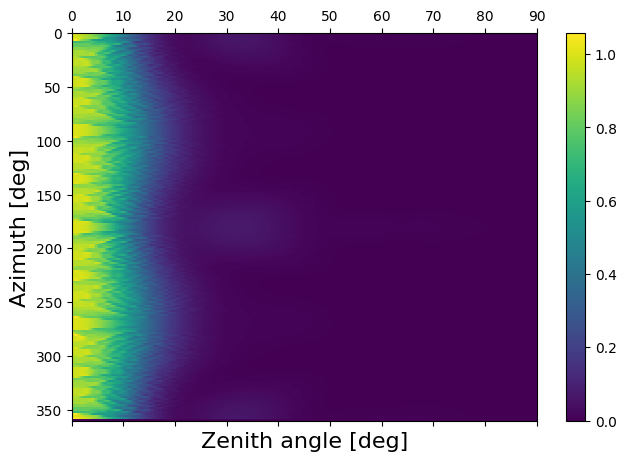

In [101]:
_az = np.linspace(0., 2.*np.pi, 200)
_za = np.linspace(0., 0.5*np.pi, 300)
az, za = np.meshgrid(_az, _za)

beams[0].peak_normalize()

b,_ = beams[0].interp(az_array=az.flatten(), za_array=za.flatten(), freq_array=np.array([freqs[0]*1e6,]))
beam = b[0,0,1,0,:].reshape(az.shape)


plt.matshow(check_c(beam.T), aspect='auto', extent=[np.rad2deg(_za.min()), np.rad2deg(_za.max()), 
                                           np.rad2deg(_az.max()), np.rad2deg(_az.min())])

plt.xlabel("Zenith angle [deg]", fontsize=16.)
plt.ylabel("Azimuth [deg]", fontsize=16.)
plt.colorbar()

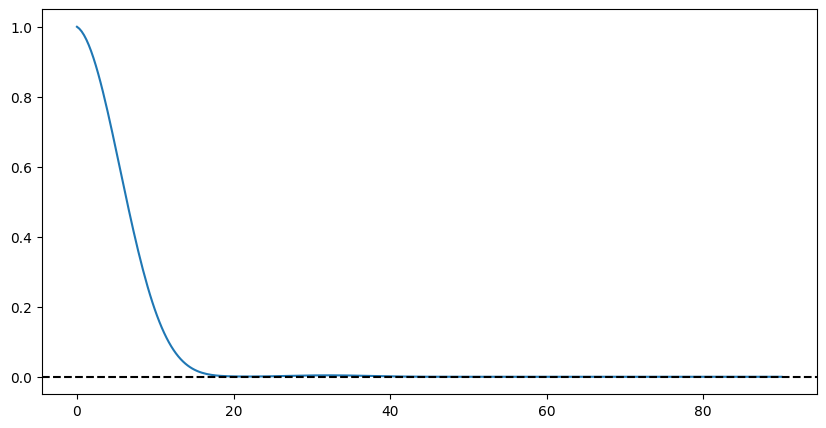

In [102]:
plt.plot(np.rad2deg(_za), beam[:,0]**2.)
plt.axhline(0., ls='dashed', color='k')

<a id='diffuse'></a>
## Diffuse emission

In [103]:
def gsm_sky_model(freqs, resolution="hi", nside=None):
    """
    Return a pyradiosky SkyModel object populated with a Global Sky Model datacube in 
    healpix format.
    Parameters
    ----------
    freqs : array_like
        Frequency array, in Hz.
    resolution : str, optional
        Whether to use the high or low resolution pygdsm maps. Options are 'hi' or 'low'.
    nside : int, optional
        Healpix nside to up- or down-sample the GSM sky model to. Default: `None` (use the 
        default from `pygdsm`, which is 1024).
    Returns
    -------
    sky_model : pyradiosky.SkyModel
        SkyModel object.
    """
    # Initialise GSM object
    gsm = pygdsm.GlobalSkyModel2016(data_unit="TRJ", resolution=resolution, freq_unit="Hz")

    # Construct GSM datacube
    hpmap = gsm.generate(freqs=freqs) # FIXME: nside=1024, ring ordering, galactic coords
    hpmap_units = "K"

    # Set nside or resample
    nside_gsm = int(astropy_healpix.npix_to_nside(hpmap.shape[-1]))
    if nside is None:
        # Use default nside from pygdsm map
        nside = nside_gsm
    else:
        # Transform to a user-selected nside
        hpmap_new = np.zeros((hpmap.shape[0], astropy_healpix.nside_to_npix(nside)), 
                             dtype=hpmap.dtype)
        for i in range(hpmap.shape[0]):
            hpmap_new[i,:] = hp.ud_grade(hpmap[i,:], 
                                         nside_out=nside, 
                                         order_in="RING", 
                                         order_out="RING")
        hpmap = hpmap_new

    # Get datacube properties
    npix = astropy_healpix.nside_to_npix(nside)
    indices = np.arange(npix)
    history = "pygdsm.GlobalSkyModel2016, data_unit=TRJ, resolution=low, freq_unit=MHz"
    freq = u.Quantity(freqs, "hertz")

    # hmap is in K
    stokes = u.Quantity(np.zeros((4, len(freq), len(indices))), hpmap_units)
    stokes[0] = hpmap * u.Unit(hpmap_units)

    # Construct pyradiosky SkyModel
    sky_model = pyradiosky.SkyModel(
                                    nside=nside,
                                    hpx_inds=indices,
                                    stokes=stokes,
                                    spectral_type="full",
                                    freq_array=freq,
                                    history=history,
                                    frame="galactic",
                                    hpx_order="ring"
                                )

    sky_model.healpix_interp_transform(frame='icrs', full_sky=True, inplace=True) # do coord transform
    assert sky_model.component_type == "healpix"
    return sky_model

In [104]:
def empty_uvdata(ants=None, nfreq=20, ntimes=20, bandwidth=0.2e8, 
                 integration_time=40., 
                 start_time=2458902.33333, start_freq=1.e8, **kwargs):
    """
    Generate empty UVData object with the right shape.
    
    Parameters
    ----------
    ants (dict): None
        A dictionary mapping an integer to a three-tuple of ENU co-ordinates for
        each antenna. These antennas can be down-selected via keywords.
    ntimes : int, optional
        Number of time samples. Default: 20.
    
    bandwidth : float
        Total bandwidth, in Hz. Default: 0.2e8
    
    integration_time : float, optional
        Integration time per time sample. Default: 40. 
    
    start_time : float, optional
        Start date of observations, as Julian date. Default: 2458902.33333 
        (20:00 UTC on 2020-02-22)
    
    start_freq : float, optional
        Initial frequency channel, in Hz. Default: 1.e8.
    
    **kwargs : args
        Other arguments to be passed to `hera_sim.io.empty_uvdata`.
    
    Returns
    -------
    uvd : UVData
        Returns an empty UVData 
    """
    from hera_sim import io
    uvd = io.empty_uvdata(
        Nfreqs=nfreq,
        start_freq=start_freq,
        channel_width=bandwidth / nfreq,
        start_time=start_time,
        integration_time=integration_time,
        Ntimes=ntimes,
        array_layout=ants,
        **kwargs
    )
    
    # Add missing parameters
    uvd._x_orientation.value = 'east'
    return uvd

In [105]:
def simulate_diffuse(freqs, beam_list, nside=64):
    
    # Construct a data model
    cfg_spec = dict( nfreq=freqs.size,
                     start_freq=freqs[0]*1e6,
                     bandwidth=(freqs[-1]-freqs[0])*1e6,
                     start_time=jd,
                     integration_time=dt,
                     ntimes=Ntimes)
    
    # Prepare empty data structure
    uvd = empty_uvdata(ants=ants, **cfg_spec)
    
    # FIXME: This can use a lot of memory in MPI mode, as there are Nprocs duplicates 
    # of the whole datacube!
    # Build SkyModel from GSM (pygdsm)
    gsm_sky = gsm_sky_model(np.unique(uvd.freq_array), resolution="lo", nside=nside)
    
    # Prepare model
    data_model = ModelData(uvdata=uvd, 
                           sky_model=gsm_sky,
                           beams=beam_list)
    
    # Initialise VisCPU handler object
    viscpu = VisCPU(precision=2)

    # Create a VisibilitySimulation object
    simulator_diffuse = VisibilitySimulation(data_model=data_model, 
                                             simulator=viscpu)
    
    # Run the simulation
    tstart = time.time()
    simulator_diffuse.simulate()
    print("\tSimulation (diffuse) took %2.1f sec" % (time.time() - tstart))
    
    # Get simulated data
    _d = uvd.get_data((0,0))
    
    # Convert from Jy to 
    assert uvd.vis_units == 'Jy'
    return _d


# Simulate in blocks of frequency
d_diffuse = np.zeros((Ntimes, Nfreqs))
#nn = Nfreqs // diffuse_sim_nblocks
#for i in range(diffuse_sim_nblocks):
#    print("Block %d / %d" % (i+1, diffuse_sim_nblocks))
#    _d = simulate_diffuse(freqs[nn*i:nn*(i+1)], beam_list=beams, nside=diffuse_nside)
#    d_diffuse[:,nn*i:nn*(i+1)] = _d.real

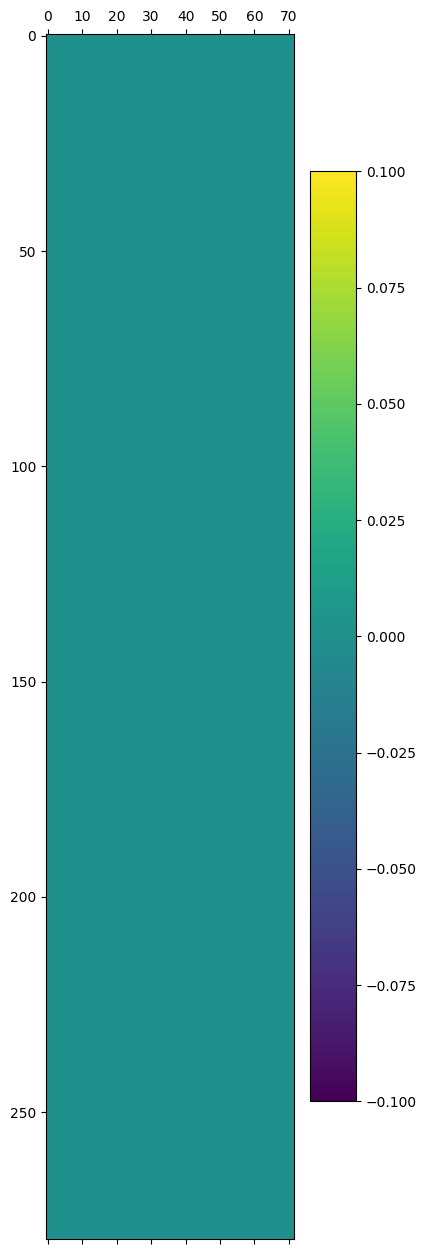

In [106]:
plt.matshow(d_diffuse.T, aspect='auto')
plt.colorbar()

In [107]:
# Plot map of diffuse emission
gsm = pygdsm.GlobalSkyModel2016(data_unit="TRJ", resolution='hi', freq_unit="Hz")

# Construct GSM datacube
hpmap = gsm.generate(freqs=freqs[0]*1e6)

invalid value encountered in log10


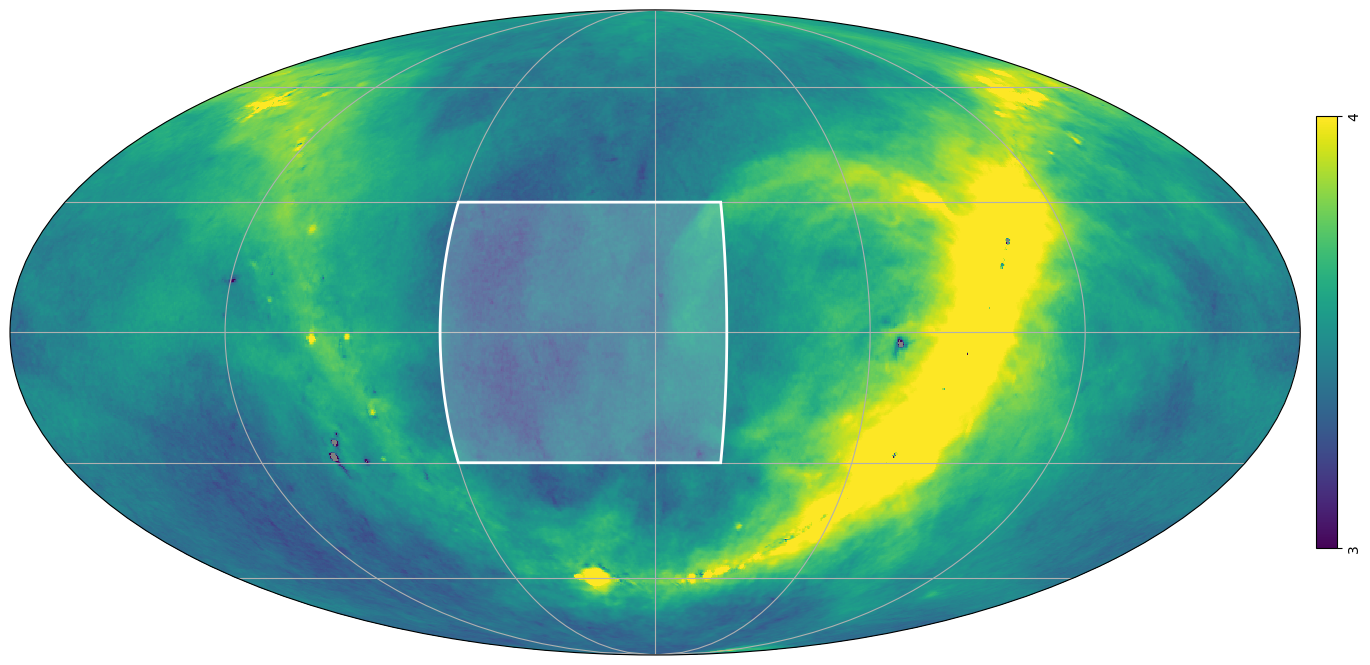

In [108]:
hp.projview(np.log10(hpmap), 
            coord=('G', 'E'), 
            rot=(-180.,0.,0.),
            flip='geo',
            min=3, 
            max=4, 
            graticule=True, 
            graticule_labels=False,
            cb_orientation="vertical",
            projection_type="mollweide")

#plt.axhline(-location.lat.deg, color='w', ls='dotted', lw=1.)
#plt.axvline(location.lat.deg, color='w', ls='dotted', lw=1.)

# Note the differenc ein coordinates between newprojplot and this
rect = patches.Rectangle((np.deg2rad(-60.), 
                          np.deg2rad(location.lat.deg-30.)),                         
                         height=np.deg2rad(60.),  
                         width=np.deg2rad(80.),  
                         ec='w', fc='w', alpha=0.2, zorder=99)
plt.gca().add_patch(rect)
rect = patches.Rectangle((np.deg2rad(-60.), 
                          np.deg2rad(location.lat.deg-30.)),                         
                         height=np.deg2rad(60.),  
                         width=np.deg2rad(80.),  
                         lw=2., ec='w', fc='none', alpha=1., zorder=99)
plt.gca().add_patch(rect)

plt.gcf().set_size_inches((16., 8.))

invalid value encountered in log10


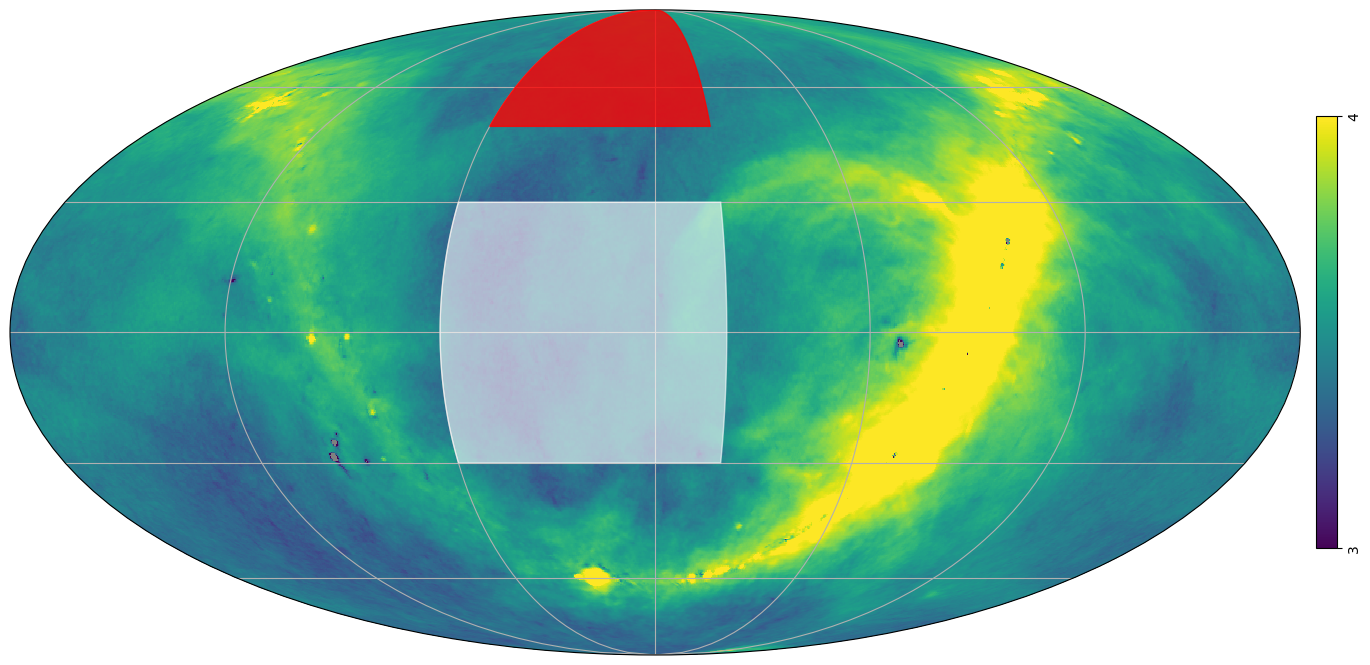

In [109]:
hp.projview(np.log10(hpmap), 
            coord=('G', 'E'), 
            rot=(-180.,0.,0.),
            flip='geo',
            min=3, 
            max=4, 
            graticule=True, 
            graticule_labels=False,
            cb_orientation="vertical",
            projection_type="mollweide")

#plt.axhline(-location.lat.deg, color='w', ls='dotted', lw=1.)
#plt.axvline(location.lat.deg, color='w', ls='dotted', lw=1.)

# Note the differenc ein coordinates between newprojplot and this
rect = patches.Rectangle((np.deg2rad(-60.), 
                          np.deg2rad(location.lat.deg-30.)),                         
                         height=np.deg2rad(60.),  
                         width=np.deg2rad(80.),  
                         ec='w', fc='w', alpha=0.6, zorder=99)
plt.gca().add_patch(rect)


rect = patches.Rectangle((np.deg2rad(-60.), 
                          np.deg2rad(78.9424-30.)),                         
                         height=np.deg2rad(41.),  
                         width=np.deg2rad(80.),  
                         ec='r', fc='r', alpha=0.8, zorder=99)
plt.gca().add_patch(rect)

#rect = patches.Rectangle((np.deg2rad(-60.), 
#                          np.deg2rad(location.lat.deg-30.)),                         
#                         height=np.deg2rad(60.),  
#                         width=np.deg2rad(80.),  
#                         lw=2., ec='w', fc='none', alpha=1., zorder=99)
#plt.gca().add_patch(rect)

plt.gcf().set_size_inches((16., 8.))

invalid value encountered in log10


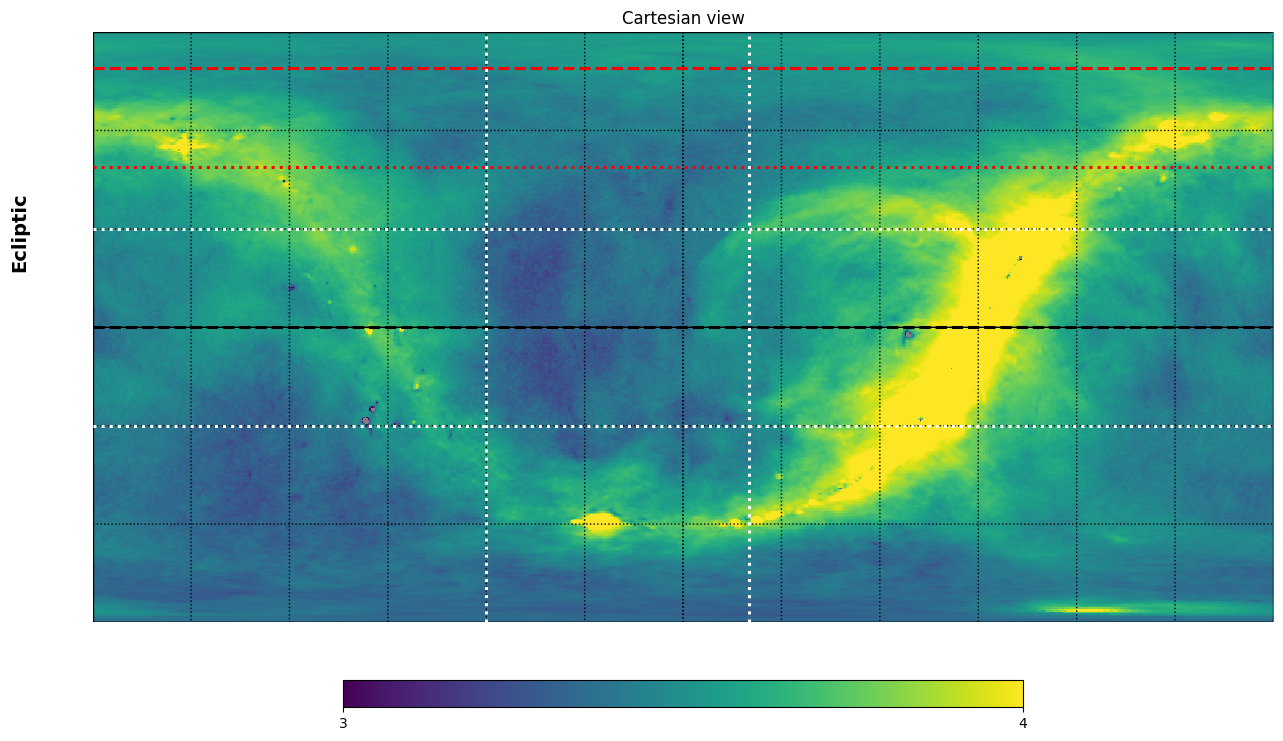

In [110]:
hp.cartview(np.log10(hpmap), 
            coord=('G', 'E'), 
            min=3, 
            max=4,
           rot=(-180.,0.,0.),
           flip='geo')
hp.graticule()

plt.axhline(location.lat.deg+30., color='w', ls='dotted', lw=2.2)
plt.axhline(location.lat.deg-30., color='w', ls='dotted', lw=2.2)
plt.axhline(location.lat.deg, color='k', ls='dashed', lw=2.2)


svalbard_lat = 78.9424
plt.axhline(svalbard_lat+30., color='r', ls='dotted', lw=2.2)
plt.axhline(svalbard_lat-30., color='r', ls='dotted', lw=2.2)
plt.axhline(svalbard_lat, color='r', ls='dashed', lw=2.2)


plt.axvline(-60., color='w', ls='dotted', lw=2.2)
plt.axvline(20., color='w', ls='dotted', lw=2.2)


plt.gcf().set_size_inches((16., 8.))

<a id='ptsrc-cat'></a>
## Point sources from catalogue

In [111]:
#import glob

In [112]:
# http://www.aoc.nrao.edu/~akimball/radiocat_1.1.shtml#download
#cat_files = glob.glob("/home/phil/hera/radiocat/*.csv")
#cat_files.sort()

In [113]:
#cat = []
#for i, fname in enumerate(cat_files):
#    print("Loading %d / %d" % (i+1, len(cat_files)))
#    _cat = np.genfromtxt(fname, skip_header=1, delimiter=',')
#    print(_cat.shape)
#    cat.append(_cat.T)

In [114]:
#cat = np.column_stack(cat)
#cat.shape

In [115]:
#plt.plot(cat[1], cat[2], 'r,', alpha=0.2)
#plt.gcf().set_size_inches((20., 10.))

<a id='ptsrc-synthetic'></a>
## Synthetic point source catalogue
GLEAM doesn't cover the northern sky well enough, but we can build a synthetic catalogue with similar properties, by resampling it.

In [116]:
# Load trimmed catalogue
cat_ra, cat_dec, cat_flux0, cat_beta = np.genfromtxt("catBC.txt").T

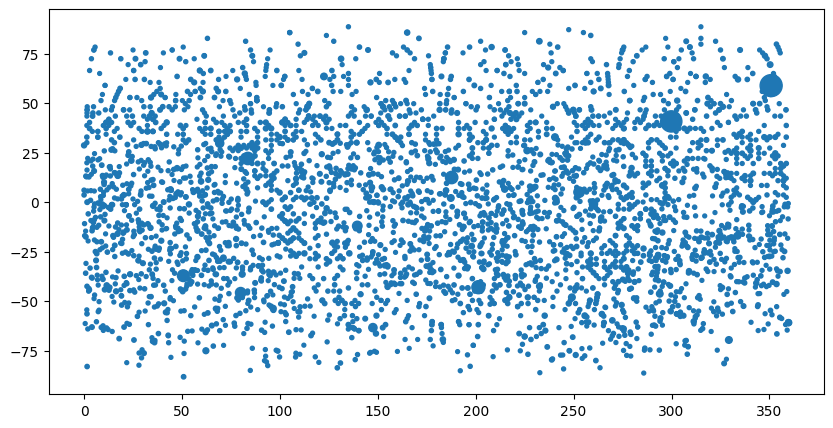

In [117]:
# Plot source positions
plt.scatter(cat_ra, cat_dec, s=2.*np.sqrt(10. + cat_flux0))

In [118]:
# Get approximate effective survey area from 3x standard deviation of RA and Dec
width_ra = 3.*np.std(cat_ra)
width_dec = 3.*np.std(cat_dec)
print(width_ra, width_dec)

# Get number density
cat_numdensity = cat_ra.size / (width_ra * width_dec) # approx. per deg^2
print("Number density: %8.4f / deg^2" % cat_numdensity)

309.8225719925748 115.99809536376006
Number density:   0.1078 / deg^2


New catalogue area: 4800.0000 deg^2
No. sources: 517


Text(0, 0.5, 'Dec [deg]')

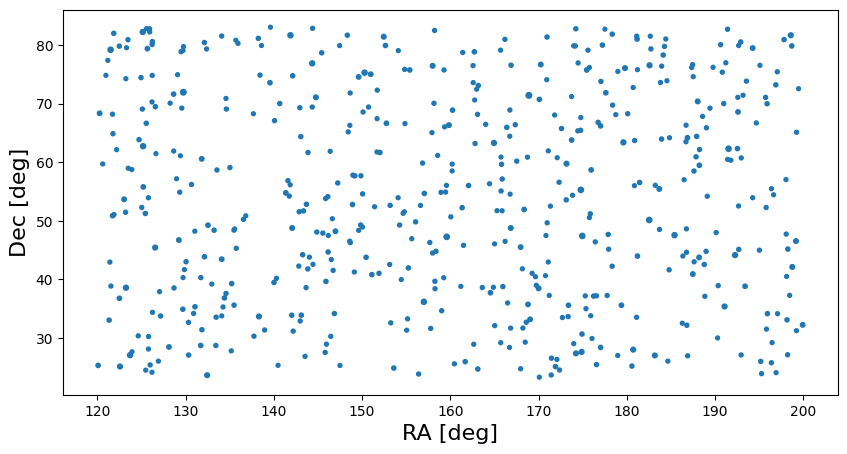

In [119]:
# Calculate new area, and therefore the number of sources (to match the number density)
ra_min, ra_max = 120., 200. # deg
dec_min, dec_max = 53.235 - 30., 53.235 + 30.
new_area = (ra_max - ra_min) * (dec_max - dec_min) # deg^2
new_Nptsrc = int(new_area * cat_numdensity)
print("New catalogue area: %8.4f deg^2" % new_area)
print("No. sources:", new_Nptsrc)

# Restrict source location on sky (close to zenith pointing)
ptsrc_ra = np.random.uniform(low=ra_min, high=ra_max, size=new_Nptsrc) # degrees
ptsrc_dec = np.random.uniform(low=dec_min, high=dec_max, size=new_Nptsrc) # degrees
ptsrc_dec[ptsrc_dec >= 90.] = 90. - (ptsrc_dec[ptsrc_dec >= 90.] - 90.)

# Select subsample of point sources at random, and use their flux and beta
idxs = np.arange(cat_ra.size)
sampled_idxs = np.random.choice(idxs, size=new_Nptsrc, replace=True)
ptsrc_flux0 = cat_flux0[sampled_idxs]
ptsrc_beta = cat_beta[sampled_idxs]

# Plot source positions in new source catalogue
plt.scatter(ptsrc_ra, ptsrc_dec, s=2.*np.sqrt(10. + ptsrc_flux0))
plt.xlabel("RA [deg]", fontsize=16)
plt.ylabel("Dec [deg]", fontsize=16)

Text(0.5, 0, '$\\log_{10} S$ [Jy]')

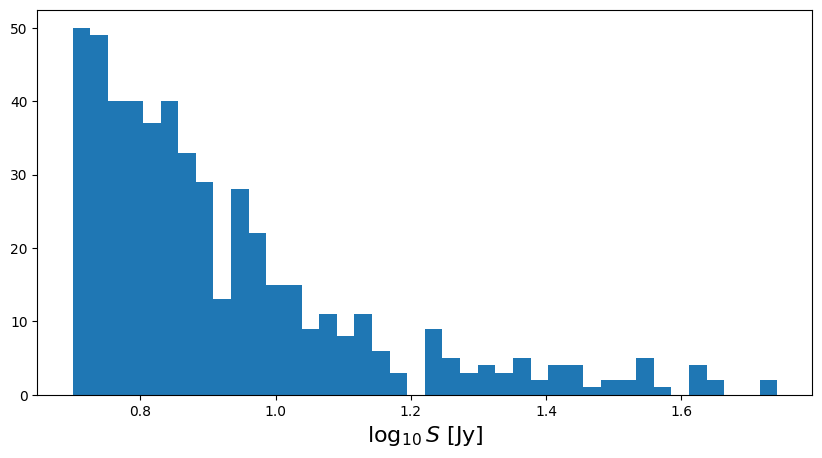

In [120]:
# Plot histogram
plt.subplot(111)
plt.hist(np.log10(ptsrc_flux0), bins=40)
#plt.yscale('log')
plt.xlabel("$\log_{10} S$ [Jy]", fontsize=16)

Text(0.5, 0, 'Point source spectral index')

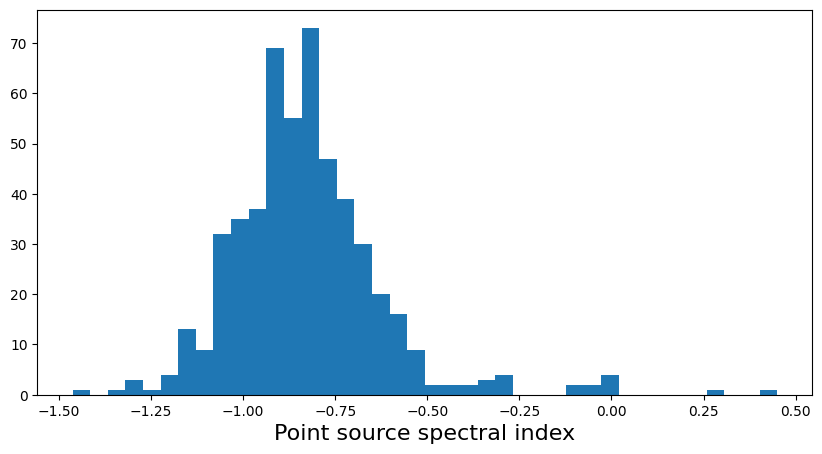

In [121]:
# Plot histogram
plt.subplot(111)
plt.hist(ptsrc_beta, bins=40)
plt.xlabel("Point source spectral index", fontsize=16.)

Done.


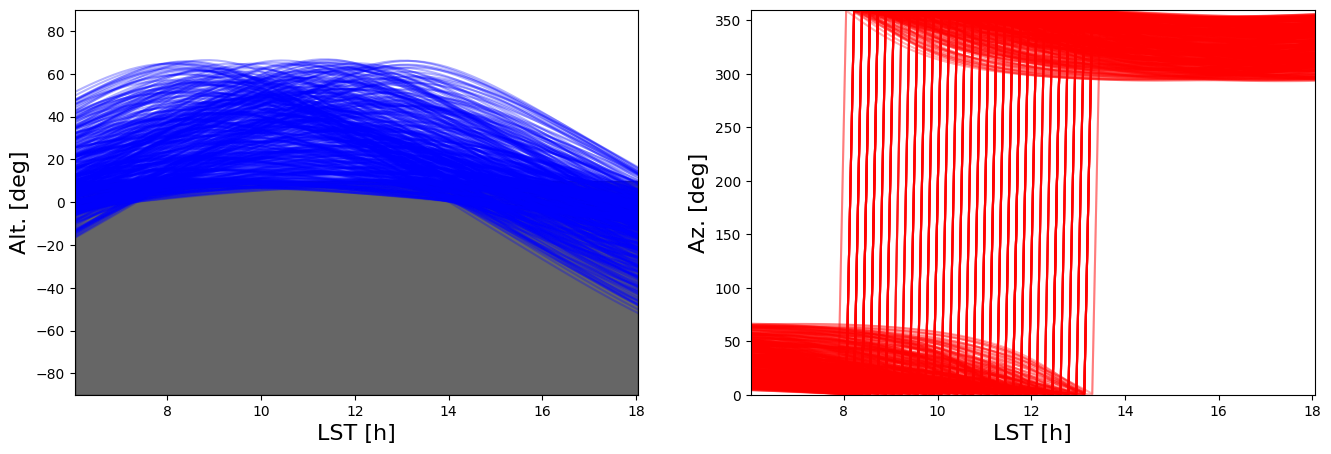

In [122]:
# Get altitude and azimuth vs LST
coords = SkyCoord(ra=ptsrc_ra*u.degree, dec=ptsrc_dec*u.degree, frame='icrs')

# Loop over times
alt, az = [], []
for tt in times:
    frame = AltAz(obstime=obstime + tt, location=location)
    _c = coords.transform_to(frame)
    alt.append(_c.alt.deg)
    az.append(_c.az.deg)
print("Done.")
alt = np.array(alt)
az = np.array(az)

# Plot altitude and azimuth vs LST
plt.subplot(121)
plt.plot(lsts*24./(2.*np.pi), alt, color='b', alpha=0.3)
plt.axhspan(xmin=0., xmax=1., ymin=-90., ymax=10., color='k', alpha=0.6)
plt.xlabel("LST [h]", fontsize=16)
plt.ylabel("Alt. [deg]", fontsize=16)
plt.xlim((lsts.min()*24./(2.*np.pi), lsts.max()*24./(2.*np.pi)))
plt.ylim((-90., 90.))

plt.subplot(122)
plt.plot(lsts*24./(2.*np.pi), az, color='r', alpha=0.3)
plt.xlabel("LST [h]", fontsize=16)
plt.ylabel("Az. [deg]", fontsize=16)
plt.xlim((lsts.min()*24./(2.*np.pi), lsts.max()*24./(2.*np.pi)))
plt.ylim((0., 360.))

plt.gcf().set_size_inches((16., 5.))

Beam FWHM:  35.8 deg


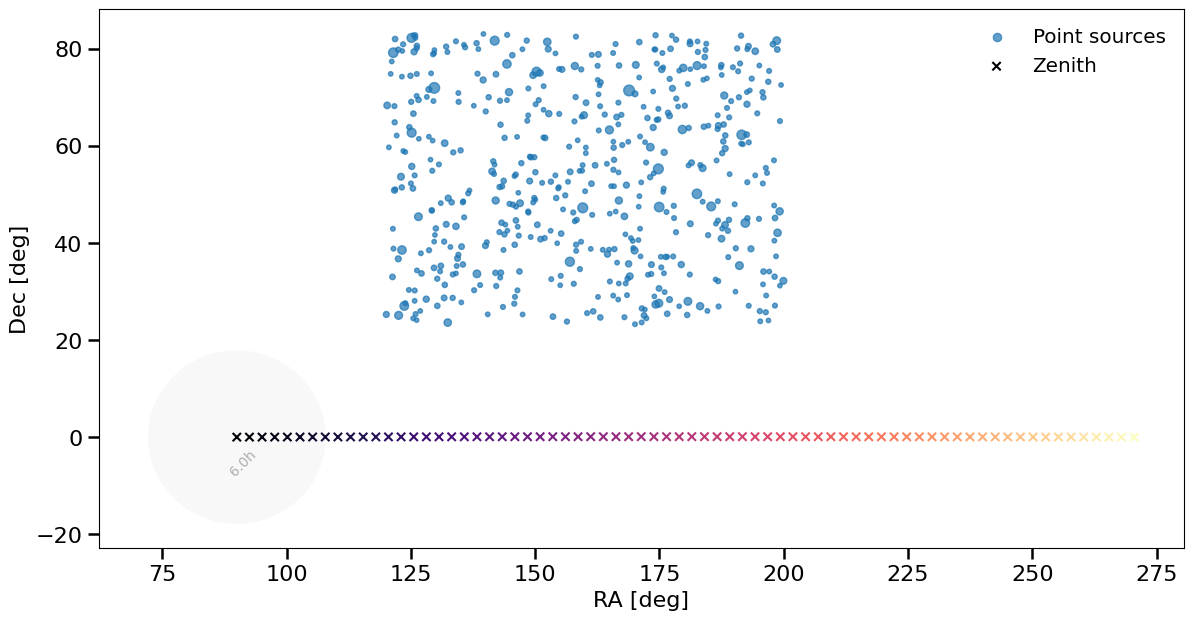

In [123]:
# Get RA/Dec track of zenith
zen_ra = []
zen_dec = []
for tt in times:
    zen = SkyCoord(alt=90.*u.deg, az=0.*u.deg, obstime=obstime + tt, location=location, frame='altaz')
    zen_ra.append(zen.icrs.ra.deg)
    zen_dec.append(zen.icrs.dec.deg)
zen_ra = np.array(zen_ra)
zen_dec = np.array(zen_dec)

# Plot locations of sources and zenith in equatorial coords
plt.subplot(111)
plt.scatter(ptsrc_ra, ptsrc_dec, s=5.+(ptsrc_flux0), label="Point sources", alpha=0.7)
plt.scatter(zen_ra, zen_dec, c=lsts, marker='x', label="Zenith", cmap='magma')

# Plot approx. beam FWHM
beam_fwhm = (astropy.constants.c.value/(freqs[0]*1e6) / 8.) * 180./np.pi
print("Beam FWHM: %5.1f deg" % beam_fwhm)
for i in np.arange(zen_ra.size)[::200]:
    circ = patches.Circle((zen_ra[i], zen_dec[i]), beam_fwhm/2., alpha=0.05, fc='gray', zorder=-100)
    plt.gca().add_patch(circ)
    if i % 2 == 0:
        plt.text(zen_ra[i] - 2., zen_dec[i] - 8., "%3.1fh" % (lsts[i]*24./(2.*np.pi)), rotation=45., alpha=0.3)

plt.legend(loc='upper right', frameon=False, prop={'size':'x-large'})
plt.xlabel("RA [deg]", fontsize=16)
plt.ylabel("Dec [deg]", fontsize=16)

#plt.ylim((-45., -15.))
plt.gca().tick_params(which='both', labelsize=16, size=8., width=1.8)

plt.gcf().set_size_inches((14., 7.))

<a id='ptsrc-sim'></a>
## Simulate point source visibilities
We use vis_cpu to simulate the point source visibilities

In [124]:
# Construct fluxes array by multiplying by powerlaw frequency dependence
fluxes = ptsrc_flux0[:,np.newaxis] * (freqs[np.newaxis,:] / 100.)**ptsrc_beta[:,np.newaxis]


In [125]:
# Simulate visibilities

try:
    beams[0].sim_start()
except:
    pass

t0 = time.time()
ptsrc_vis = vis_cpu.simulate_vis(ants=ants, 
                                 fluxes=fluxes[:1], 
                                 ra=np.deg2rad([180]), 
                                 dec=np.deg2rad([0]), 
                                 freqs=freqs*1e6, 
                                 lsts=lsts, 
                                 beams=beams, 
                                 precision=2, 
                                 polarized=False,
                                 latitude=location.lat.rad)
print("Run took %3.1f sec" % (time.time() - t0))

try:
    beams[0].sim_end()
except:
    pass



Run took 29.1 sec


Text(0.5, 0, 'Observation time [hr]')

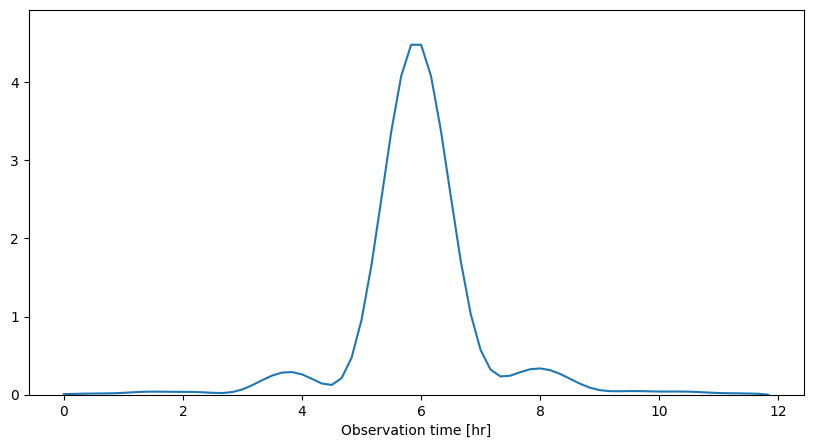

In [126]:

plt.ylim(0,  np.max(np.abs(ptsrc_vis[0, :, 0, 0]))*1.1)
plt.plot(np.arange(Ntimes)*dt/3600, np.abs(ptsrc_vis[0, :, 0, 0]))
plt.xlabel("Observation time [hr]")